# Apply Neural Networks to the Stock Market

Notebook to explore limited set of NY stock exchange data over around 40 years, as part of the Portland Data Science group (Mar 2018).
Data selected by Matt Borthwick from Yahoo! Finance.
Working with Neural Network group: Matt, John Burt, Manny, Isil, Kenny, Jhoan, Mark C.

Our goal is to predict weekly returns on 6 industry based ETFs, as well
as aggregate market performance (such as Russel3000).  We will also
be using some macroeconomic indicators as well.
This notebook currently loads the data, transforms it, and applies a
simple neural network to try predicting the next days stock prices.
The first model was built in tensorflow (and is currently broken).  THere is a second network written in Keras.

The plan is to train on this data (up to Sep 2017),
validate on (Oct-Dec 2017), and test in final session on (Jan-Mar 2018).

(For more exploratory screwing around, and other attempts at time-series see PDX_finance1)

Currently Contains:
-Colab setup
-Loading data
-Tensorflow RNN (currently borked at prediction stage - wrong size? No idea what changed)
-Keras RNN  (not working yet)
-Keras Deep network

# Google Colab setup

First up however, we need to install modules to load up our google drive for storage.  (Code taken from this helpful post https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d)
(Code and commands didn't look sketchy/malicious, but I didn't examine the PPA too closely either.)

This code is for execution inside a Jupyter notebook on colab.google.com.
It gives Colab access to your Google Drive in order to load/save data from within the notebook.
Colab has most popular libraries (numpy, pandas, tensorflow, matplotlib).  I'm not sure how extensive it is.

I've found opening a jupyter notebook on google drive automatically opens the Colab.

In [ ]:
#Install modules on local machine.
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!echo 'past update'
!apt-get -y install -qq google-drive-ocamlfuse fuse
!echo 'installed fuse'

In [ ]:
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
print('past first command')
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [ ]:
#Mounts google drive, and changes to that directory
!mkdir -p drive 
!google-drive-ocamlfuse drive

import os
os.chdir("drive")

#Should now be in the root of your google-drive, and now free to load/save existing files.

# Load Libraries and Data

Now to load libraries, and data for all stocks, ETFs, and indicators.
All of those will get stuck together into one total dataframe.
(This is where I start my analysis on my home machine.)

In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
# automatically reload files.
%load_ext autoreload
%autoreload 2

In [1]:
def load_stock_data():

    #Data compiled from Yahoo! Finance data by Matt Borthwick
    df_close=pd.read_csv('data/stocks-us-adjClose.csv',index_col=0,parse_dates=True)
    df_open=pd.read_csv('data/stocks-us-adjOpen.csv',index_col=0,parse_dates=True)
    df_high=pd.read_csv('data/stocks-us-adjHigh.csv',index_col=0,parse_dates=True)
    df_low=pd.read_csv('data/stocks-us-adjLow.csv',index_col=0,parse_dates=True)
    df_vol=pd.read_csv('data/stocks-us-Volume.csv',index_col=0,parse_dates=True)
    df_close.index.name='date'
    df_open.index.name='date'
    df_high.index.name='date'
    df_low.index.name='date'
    df_vol.index.name='date'

    #Follow Leffers and rename columns.
    df_close_new=[];
    df_open_new=[];
    df_low_new=[];
    df_high_new=[];
    df_vol_new=[];

    for name in df_close.columns:
        df_close_new.append(name+'close')

    for name in df_open.columns:
        df_open_new.append(name+'open')

    for name in df_low.columns:
        df_low_new.append(name+'low')

    for name in df_high.columns:
        df_high_new.append(name+'high')

    for name in df_vol.columns:
        df_vol_new.append(name+'vol')

    df_close.columns=df_close_new
    df_open.columns=df_open_new
    df_low.columns=df_low_new
    df_high.columns=df_high_new
    df_vol.columns=df_vol_new

    #join all stocks together.
    df_stock=df_close.join(df_open,how='inner')
    df_stock=df_stock.join(df_high,how='inner')
    df_stock=df_stock.join(df_low,how='inner')
    df_stock=df_stock.join(df_vol,how='inner')

    return df_stock


In [3]:
ls data

Company_information.csv  market.csv                   stocks-us-adjHigh.csv
df_tot.pickle            sector_etfs-2-corrected.csv  stocks-us-adjLow.csv
indicators_test.csv      sector_etfs.csv              stocks-us-adjOpen.csv
Indicators_Test.csv      sector_ETFs.csv              stocks-us-moreData.zip
Indicators_Train.csv     stocks-us-adjClose.csv       stocks-us-Volume.csv


In [3]:
#so columns match up
print(np.sum(df_close.columns!=df_low.columns),
np.sum(df_close.columns!=df_high.columns),
np.sum(df_close.columns!=df_open.columns),
np.sum(df_close.columns!=df_vol.columns))
#and indices match up.
print(np.sum(df_close.index!=df_low.index),
np.sum(df_close.index!=df_high.index),
np.sum(df_close.index!=df_open.index),
np.sum(df_close.index!=df_vol.index))


0 0 0 0
0 0 0 0


In [9]:
?pd.read_csv

In [10]:
df_market=pd.read_csv('data/market.csv',index_col=0,parse_dates=True)
df_rua=pd.read_csv('data/^RUA.csv',index_col=0,parse_dates=True)


In [11]:
df_rua.head()

                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2018-03-08  1616.369995  1622.140015  1612.140015  1621.239990  1621.239990   
2018-03-09  1623.890015  1648.469971  1623.890015  1648.459961  1648.459961   
2018-03-12  1649.469971  1654.329956  1644.829956  1647.410034  1647.410034   
2018-03-13  1650.979980  1657.670044  1633.640015  1637.189941  1637.189941   
2018-03-14  1638.829956  1643.849976  1625.569946  1628.189941  1628.189941   

           Volume  
Date               
2018-03-08      0  
2018-03-09      0  
2018-03-12      0  
2018-03-13      0  
2018-03-14      0  

In [13]:
df_etf=load_etfs()

In [15]:
df_etf.columns

Index(['Basic Materials (IYM)', 'Consumer Goods (IYK)', 'Healthcare (IYH)',
       'Market (^RUA)', 'Services (IYC)', 'Technology (IYW)',
       'Utilities (IDU)'],
      dtype='object')

In [18]:
df_etf.plot(logy=True)

In [35]:
etf_cols=['Technology (IYW)', 'Basic Materials (IYM)', 'Consumer Goods (IYK)',
       'Services (IYC)', 'Healthcare (IYH)', 'Utilities (IDU)',
       'Market (^RUA)']

In [47]:
def test_re(etf_cols):
    df_tot=pd.DataFrame()
    for etf_name in etf_cols:
        mc=re.search(etf_re,etf_name)
        print(mc.match)

In [69]:
    for etf_name in etf_cols:
        mc=re.search('\(([A-Z\^]+)\)',etf_name)
        print(mc.group(1))

IYW
IYM
IYK
IYC
IYH
IDU
^RUA


In [117]:
?pd.read_csv

In [138]:
import re
def clean_new_etfs(etf_cols):
    df_tot=pd.DataFrame()
    for etf_name in etf_cols:
        #match via regex
        mc=re.search('\(([A-Z\^]+)\)',etf_name)
        #retrieve the match
        etf_ticker=mc.group(1)      
        df=pd.read_csv('data/latest_etf/'+etf_ticker+'.csv', index_col=0,parse_dates=True,na_values='null')
        df.rename(columns={'Adj Close':etf_name},inplace=True)
        #only join based on adjusted close

        #Kill missing values via linear interpolation.
        ser=df.iloc[:,4].copy()
        msk=np.isnan(ser.values)
        ind=np.arange(len(ser))[msk]
        #replace multiple NA with median.
        ser[msk]=ser.median()
        #for isolated values, replace by the average on either side.    
        for i in ind:
            ser.iloc[i]=(ser.iloc[i-1]+ser.iloc[i+1])/2
        ser.reindex(df.index )
        df_tot=df_tot.join(ser,how='outer')
    return df_tot    

In [139]:
df_etf3=clean_new_etfs(etf_cols)

In [144]:
df_etf3.to_csv('data/sector_etf_Sep17-Apr18.csv')

In [143]:
i=5
plt.figure()
plt.plot(df_etf2[etf_cols[i]],label=etf_cols[i]+'-2')
plt.plot(df_etf3[etf_cols[i]],label=etf_cols[i]+'-3')
plt.legend()
plt.show()


In [111]:
df_etf3[etf_cols[i]]

Date
2017-09-01    1465.449951
2017-09-05    1453.699951
2017-09-06    1457.770020
2017-09-07    1456.829956
2017-09-08    1455.250000
2017-09-11    1471.199951
2017-09-12    1476.680054
2017-09-13    1477.709961
2017-09-14    1476.099976
2017-09-15    1479.280029
2017-09-18    1482.530029
2017-09-19    1483.800049
2017-09-20    1485.489990
2017-09-21    1481.260010
2017-09-22    1482.859985
2017-09-25    1480.030029
2017-09-26    1480.459961
2017-09-27    1488.369995
2017-09-28    1490.339966
2017-09-29    1495.430054
2017-10-02    1502.630005
2017-10-03    1506.010010
2017-10-04    1507.439941
2017-10-05    1515.310059
2017-10-06    1513.689941
2017-10-09    1510.489990
2017-10-10    1513.959961
2017-10-11    1516.290039
2017-10-12    1514.000000
2017-10-13    1514.890015
                 ...     
2018-02-23    1621.739990
2018-02-26    1639.170044
2018-02-27    1618.089966
2018-02-28    1600.150024
2018-03-01    1581.170044
2018-03-02    1591.380005
2018-03-05    1608.609985
2018-03

In [108]:
df_etf2.iloc[:,6]

Date
2017-09-11    1471.199951
2017-09-12    1476.680054
2017-09-13    1477.709961
2017-09-14    1476.099976
2017-09-15    1479.280029
2017-09-18    1482.530029
2017-09-19    1483.800049
2017-09-20    1485.489990
2017-09-21    1481.260010
2017-09-22    1482.859985
2017-09-25    1480.030029
2017-09-26    1480.459961
2017-09-27    1488.369995
2017-09-28    1490.339966
2017-09-29    1495.430054
2017-10-02    1502.630005
2017-10-03    1506.010010
2017-10-04    1507.439941
2017-10-05    1515.310059
2017-10-06    1513.689941
2017-10-09    1510.489990
2017-10-10    1513.959961
2017-10-11    1516.290039
2017-10-12    1514.000000
2017-10-13    1514.890015
2017-10-16    1517.150024
2017-10-17    1517.500000
2017-10-18    1519.130005
2017-10-19    1519.349976
2017-10-20    1527.189941
                 ...     
2017-11-03    1532.270020
2017-11-06    1534.619995
2017-11-07    1532.140015
2017-11-08    1534.449951
2017-11-09    1528.400024
2017-11-10    1527.489990
2017-11-13    1528.849976
2017-11

In [22]:
df_etf = pd.read_csv('data/sector_ETFs.csv',index_col=0,parse_dates=True)
df_etf2 = pd.read_csv('data/sector_etfs-2-corrected.csv',index_col=0,parse_dates=True)

df_etf2.columns

Index(['Technology (IYW)', 'Basic Materials (IYM)', 'Consumer Goods (IYK)',
       'Services (IYC)', 'Healthcare (IYH)', 'Utilities (IDU)',
       'Market (^RUA)'],
      dtype='object')

In [12]:
def load_etfs():

    #load market/ETF data

    df_etf = pd.read_csv('data/sector_ETFs.csv',index_col=0,parse_dates=True)
    df_etf2 = pd.read_csv('data/sector_etfs-2-corrected.csv',index_col=0,parse_dates=True)
    df_etf=df_etf.append(df_etf2)
    
    return df_etf


def load_market():

    df_market=pd.read_csv('data/market.csv',index_col=0,parse_dates=True)
    df_rua=pd.read_csv('data/^RUA.csv')
    

def make_target_df(df_etf,df_market):
    df_target=pd.DataFrame.join(df_etf,other=df_market,how='outer')
    return df_target
    
def load_indicators():

    # remove warnings
    import csv
    import warnings

    ##Pieter Leffer's code for reading in indicators
    warnings.filterwarnings('ignore')

    # Leffers ran into errors importing the file because of non-ascii characters in the heading
    #Here is a piece of code Leffers got from stack overflow to fix that problem.
    df_ind=[]
    with open('data/Indicators_Train.csv', newline='', encoding='utf-8', errors='ignore') as f:
        reader = csv.reader(f)
        for row in reader:
            df_ind.append(row)

    df_ind=pd.DataFrame(df_ind)
    df_ind.columns=df_ind.iloc[0]
    Column_Reference=df_ind.iloc[1].copy()
    #Drop useless rows (last row is empty)
    df_ind.drop([0,1],axis=0,inplace=True)


    # #Change the formatting of the variables. Datetime to the ones for dates, integers for the ones that aren't
    for i in range(0,len(df_ind.columns)):
        col_name=df_ind.columns[i]
        if i % 2 == 1:
            df_ind[col_name] = pd.to_datetime(df_ind[col_name],  format = '%m/%d/%Y',  errors='coerce')
            print(col_name,'time')
        else:
            df_ind[col_name] = pd.to_numeric(df_ind[col_name], errors='ignore')
            print(col_name,'val')

    # #Reset the index because we dropped rows in the DataFrame, Using the drop command to remove the old index
    df_ind.reset_index(drop=True, inplace=True)

    # #make a time index too.
    df_ind.index=pd.DatetimeIndex(df_ind['date'])

    # #drop all NaTs
    msk=np.isnat(df_ind.index)
    df_ind=df_ind[~msk]
    df_ind.drop(df_ind.columns[[0,1]],axis=1,inplace=True)
    return df_ind

In [ ]:
?df_ind.drop

In [5]:
df_stocks=load_stock_data()


In [6]:
df_target=load_target()

In [38]:
df_ind=load_indicators()

 val


date time
HOUST val


HOUST_dt time
UNRATENSA val


UNRATENSA_dt time
EMRATIO val


EMRATIO_dt time
UEMPMED 

val
UEMPMED_dt time
UMCSENT val


UMCSENT_dt time
USSLIND val
USSLIND_dt time


KCFSI val
KCFSI_dt time
IPMAN val


IPMAN_dt time
VIXCLS val
VIXCLS_dt time
DGS10 val


DGS10_dt time


In [40]:
df_ind.head()

0           HOUST HOUST_dt  UNRATENSA UNRATENSA_dt  EMRATIO EMRATIO_dt  \
date                                                                     
1970-01-02    NaN      NaT        NaN          NaT      NaN        NaT   
1970-01-03    NaN      NaT        NaN          NaT      NaN        NaT   
1970-01-04    NaN      NaT        NaN          NaT      NaN        NaT   
1970-01-05    NaN      NaT        NaN          NaT      NaN        NaT   
1970-01-06    NaN      NaT        NaN          NaT      NaN        NaT   

0           UEMPMED UEMPMED_dt  UMCSENT UMCSENT_dt  USSLIND USSLIND_dt  KCFSI  \
date                                                                            
1970-01-02      NaN        NaT      NaN        NaT      NaN        NaT    NaN   
1970-01-03      NaN        NaT      NaN        NaT      NaN        NaT    NaN   
1970-01-04      NaN        NaT      NaN        NaT      NaN        NaT    NaN   
1970-01-05      NaN        NaT      NaN        NaT      NaN        NaT    Na

In [13]:
#drop those time columns
Nind=10

In [12]:
#keep numbers of Stocks, ETFS, indicators.
Nstocks_tot=int(df_stocks.shape[1]/5)
Netf=7
Nind=10

In [13]:
#make vectors of indices in total to extract together.  
close_ind=np.arange(0,Nstocks_tot)
open_ind=np.arange(Nstocks_tot,2*Nstocks_tot)
high_ind=np.arange(2*Nstocks_tot,3*Nstocks_tot)
low_ind=np.arange(3*Nstocks_tot,4*Nstocks_tot)
vol_ind=np.arange(4*Nstocks_tot,5*Nstocks_tot)
ind_ind=np.arange(5*Nstocks_tot,5*Nstocks_tot+Nind)
etf_ind=np.arange(5*Nstocks_tot+Nind,5*Nstocks_tot+Nind+Netf)

#make global array of indices to take logs/differences of
#take differences for stock prices and ETF data
diff_ind = np.append(np.arange(4*Nstocks_tot),etf_ind)
#take logs for stock prices, volumes and ETFs.
log_ind = np.append(np.arange(5*Nstocks_tot),etf_ind)

In [41]:
#append indicators to end of dataframe.
drop_col_num=df_ind.columns.str.contains('[date]|[_dt]')
keep_col=df_ind.columns[~drop_col_num]
print(keep_col)

Index(['HOUST', 'UNRATENSA', 'EMRATIO', 'UEMPMED', 'UMCSENT', 'USSLIND',
       'KCFSI', 'IPMAN', 'VIXCLS', 'DGS10'],
      dtype='object', name=0)


In [43]:
join_num=np.arange(1,len(df_ind.columns),2)
df_tot=df_stocks.join(df_ind.loc[df_stocks.index,keep_col],how='left')
df_tot=df_tot.join(df_target,how='left')


In [44]:
import pickle

In [47]:
#dump dataframe as pickle object for ease.
file_name='data/df_tot.pickle'
fileObj=open(file_name,'wb')
pickle.dump(df_tot,fileObj)
fileObj.close()

In [46]:
#Plots the scaled values of the economic indictors.
sl=slice(1,-2,2)
df_ind_scale=df_ind.iloc[:,sl].abs().max()
cutoff=int(len(df_ind)/2)
plt.plot(df_ind.iloc[cutoff:,sl]/df_ind_scale)
plt.show()

TypeError: ufunc 'absolute' did not contain a loop with signature matching types dtype('<M8[ns]') dtype('<M8[ns]')

Looking at the number of NA values (summed across columns) suggests that
there are missing values in these stocks.

Could set all NA to zero, then apply linear interpolation to handle isolated
missing days.  Let's check the pattern of missing days.

In [9]:
#Plot pattern of NA values.  Weird stripes?
plt.figure(figsize=(10,6))
col=df_close.columns[0:]
plt.imshow(np.isnan(df_vol.loc['2000':,col]),aspect='auto')
plt.show()

So, some stopped stocks, and one out of place one where 

# Data Transformation

For the initial testing, I'm just building a model based on the 100 oldest stocks (or whichever come first), and looking at 2002-2006.
Why then?  Because it looks relatively well behaved.
The model is trained on the first half of the data, and we then run the
network on the whole data set.

I'm currently just taking the base-10 log of the data, and scaling each
stock to lie with [-1,1].  I found differencing the data lead to
pretty crappy results (then again, these are also pretty crap results).

So there's some choices to be played with here:
- scaling: variance vs max/min
- differencing?

In [202]:
Nstocks=300
Xsub=df_tot['2000':'2006'].iloc[:,:Nstocks].values

def scale_clean_data(X):
    #set missing values to zero.  (to avoid issues in network with NaNs)
    X[np.isnan(X)]=0
    #take differences of logs. (shift zero to avoid NANs)
    #Xsub2 = np.diff(np.log10(Xsub+1E-12),axis=0)
    X = np.log10(Xsub+1E-16)

    X_max = np.max(X,axis=0)
    X_min = np.min(X,axis=0)

    #Choice of scaling here: max/min vs variance?
    #I think variance makes more sense if differencing.
    rng = 0.5*(X_max-X_min)
    avg = 0.5*(X_max+X_min)
    Xscaled= (X-avg)/rng
    return Xscaled,rng,avg

Xsub2,rng,avg=scale_clean_data(Xsub)

#split 3/4 as training, 1/4 as test
N=len(Xsub2)
Nc=int(3*N/4)
#make training/test splits
Xtrain = Xsub2[:Nc]
ytrain = Xsub2[1:Nc+1] #tomorrow's return.

Xtest=Xsub2[Nc:-1]
ytest=Xsub2[Nc+2:]

In [157]:
def take_log10(X):
    """take_log10(X)
    Takes base10-log of X.  Sets NaN to zero, and shifts zero values by 1E-16.
    """
    #set missing values to zero.  (to avoid issues in network with NaNs)
    y=X.copy()
    y[np.isnan(y)]=0    
    #take logs. (shift zero to avoid NANs)
    y[:,log_ind] = np.log10(y[:,log_ind]+1E-16)
    return y

def scale_maxmin(X):
    """scale_maxmin

    Scales each price column by taking log, and max/min scaling.
    Takes log of open/high/low/volumes/etf.
    Does not take log of indicators.
    Max-min scales all of them.
    Only take the log for the stock/etf data.
    """
    X=take_log10(X)
    X_max = np.nanmax(X,axis=0)
    X_min = np.nanmin(X,axis=0)
    #compute middle and differences of the max/min.
    avg = 0.5*(X_max+X_min)
    rng = 0.5*(X_max-X_min)
    #scale to [-1,+1]
    Xscaled= (X-avg)/rng
    return Xscaled,rng,avg

def rescale_maxmin(Xscaled,avg,rng):
    """rescale_maxmin

    Undoes log-max/min scaling. 
    First undoes max/min scaling.  
    Then exponentiates varaibles which had log taken.
    """
    #set missing values to zero.  (to avoid issues in network with NaNs)
    X= avg + rng*Xscaled
    #take logs. (shift zero to avoid NANs)
    X[:,log_ind] = 10**X[:,log_ind]
    return X

def scale_diff_var(X):
    """scale_diff_var
    Scales each column by taking log, then differencing.
    Then scales to have zero mean, and unit standard deviation..
    Only take the log for the stock/etf data.
    """
    X=take_log10(X)
    #take differences logs. (shift zero to avoid NANs)    
    X[:,diff_ind] = np.diff(X[:,diff_ind],axis=0)
    X_std = np.nanstd(X,axis=0)
    X_mean = np.nanmean(X,axis=0)
    Xscaled= (X-X_mean)/X_std
    return Xscaled,X_mean,X_std

def rescale_diffvar(Xscaled,mu,sd,x0):
    """rescale_maxmin

    Undoes log-max/min scaling. 
    Takes log of open/high/low/volumes/etf.
    Does not take log of indicators.
    Max-min scales all of them.
    Only take the log for the stock/etf data.
    """
    #set missing values to zero.  (to avoid issues in network with NaNs)
    X= mu + sd*Xscaled
    X= np.insert(X,0,x0,axis=0)
    X[:,diff_ind] = np.cumsum(X[:,diff_ind],axis=0)
    #take logs. (shift zero to avoid NANs)
    X[:,log_ind] = 10**X[:,log_ind]
    return X

In [13]:
#check scaling
plt.figure()
plt.plot(Xtrain[:,0:5])
plt.plot(ytrain[:,0:5])
plt.show()

# Neural Network

This model is just a test based purely on the stock data.
The network uses a multi-layer RNN, with two hidden layers at input/output.  They use leaky ReLU activation.
The model currently plays with 100 stocks from 2002-2006.

This uses a model I've cobbled together in Tensorflow.
The OO structure is borrowed from the online problem sets
from CS224 on NLP offered in 2017 at Stanford.
The NN is borrowed from A. Geron "Hands on Machine Learning with Scikit-Learn and Tensorflow", which I've found to be the best
overall introduction, and has a good mix of background, and code.
(There is also an associated Github account with code).

The Tensorflow docs were pretty hard reading, and there seem to be lots
of tricks that only practitioners on StackOverflow are aware of.  (But the tutorials are pretty readable.)

Note network currently only predicts one timestep into the future. 


In [153]:
import tensorflow as tf
from neural_networks.recurrent_network import recurrent_NN

# Fitting RNN

In [14]:
#define network.
#Note a lot of network parameters are defined in __init__ in "recurrent_network.py".
#A more robust structure would pass a config dict or something like that.
RNN=recurrent_NN(60,Nstocks,100,Nstocks,'LSTM')

(LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_2:0' shape=(?, 100) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_3:0' shape=(?, 100) dtype=float32>), LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_4:0' shape=(?, 100) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_5:0' shape=(?, 100) dtype=float32>))
Tensor("strided_slice:0", shape=(2, ?, 300), dtype=float32)


In [15]:
#Rebuild the tensorflow graph.
RNN.build()
#Actually train the graph on first half of data.
#Give all of the data to this subroutine, where it selects
# the inputs and target data in get_random_batch

RNN.train_graph(Xtrain,Xtrain,save_name='tf_models/rnn_test')
#Note the tiny, tiny errors.  Probably badly overfitting.
#Need to fix the dropout so it's only on in training.

iter #20. Current MSE:0.22016216814517975
Total Time taken:21.250980377197266




KeyboardInterrupt: 

In [19]:
%pdb on

Automatic pdb calling has been turned ON


In [158]:
#Predict on all of the data.
#This loads up a previous model.
#RNN_pred=RNN.predict_all('tf_models/rnn_test',20,Xsub2,reset=True)

In [11]:
def plot_pred(X,pred,indx_range):
    """Plots a particular stock and the prediction"""

    plt.figure()
    plt.subplot(121)
    plt.plot(X[:,indx_range])
    plt.plot(pred[:,indx_range])
    plt.plot([len(X)/2]*2,[-1,1],'k-')
    plt.legend(['Actual','Forecast'])
    plt.title('Raw')

    plt.subplot(122)
    plt.plot(np.cumsum(X[:,indx_range],axis=0))
    plt.plot(np.cumsum(pred[:,indx_range],axis=0))
    plt.legend(['Actual','Forecast'])    
    plt.title('Cumulative')

    plt.show()
    

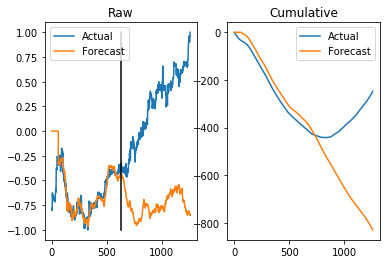

In [17]:
#Could make predicted results a time series for nicer formating, and dates.
#Plot cumulative for cases when we've also differenced.
plot_pred(Xsub2,RNN_pred,50)

This RNN forecast is also WAY worse than a persistence forecast (tomorrow's price is the same as todays).
Big question: why is the price wandering away? Even if the model is fixed (weights unchanged), surely it should take the recent past (which the model uses to forecast tomorrow's demand) into account.

Note the effect of further smoothing, which suggests a clearer trend, that might be easier to model.
That suggests the convolutional networks may be useful,
perhaps with running averages to smooth the data.  Forecasting on a week timescale might allevative some of that too?

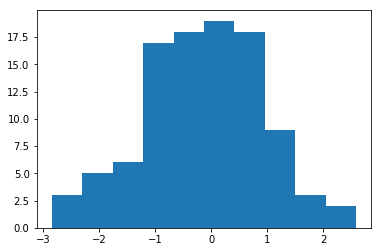

In [13]:
#Let's look at the differences between the predicted and actual
#results at the end of the period.
pred_diff=RNN_pred[-1]-Xsub2[-1]
plt.hist(pred_diff)
plt.show()

In [15]:
(np.mean(pred_diff),np.std(pred_diff))

(-0.1433746024133806, 1.0660086500156463)

In [104]:
#Let's now see how much the predictions vary (across all stocks) at the end of training, 20 trading days after that,
# and at the end of the period, a year or two out.

#Note that these predictions use the data from those periods, but the model is not being updated.

def plot_err_hist(target,pred,Nc):
    '''plot_err_hist

    Makes histograms of the errors between the target and prediction
    at multiple time scales aroud the tend of the training period.
    '''
    
    Nc = int(len(Xsub2)/2)
    plt.figure(figsize=(10,6))

    plt.subplot(141)
    pred_diff=pred[Nc-20]-target[Nc-20]
    plt.title('End of training - 20 days')
    plt.hist(pred_diff)

    plt.subplot(142)
    pred_diff=pred[Nc]-target[Nc]
    plt.title('End of training')
    plt.hist(pred_diff)

    plt.subplot(143)
    pred_diff=pred[Nc+20]-target[Nc+20]
    plt.title('End of training+20 days')
    plt.hist(pred_diff)

    plt.subplot(144)
    pred_diff=pred[-1]-target[-1]
    plt.hist(pred_diff)
    plt.title('End of test')
    plt.xlabel('Forecast Residuals')
    plt.show()


The final graph is worst, it is also trying to predict many years ahead, based on essentially short-term info.
Probably could describe build up of cumulative errors as a random walk?
Would guess errors grows as sqrt(T), so the variance of this distribution grows as T.


# Keras Recurrent Neural Network

Let's build a similar recurrent network in Keras (just using the adjusted close for now). 

The goal is to predict the a whole quarters worth of weekly returns on 6 sectors, denoted by $\mathbf{y}_{t}$, based on a sequence of inputs $\mathbf{x}_{t}$, which can be (stocks, previous values of the inputs, macroeconomic indicators ).

We will use a recurrent network, which should map a whole sequence of previous inputs to another sequence of output vectors.
\begin{equation}
  \hat{y}_{t+n} = RNN(\mathbf{x}_t,\mathbf{x}_{t-1},\ldots \mathbf{x}_{t-\tau})
\end{equation}
where $\tau$ is the maximum period we look back over, and $n$ is the number of periods we are looking forward over.

Ideally, we would use all output times together to predict the outputs.
I think a reshape is in order here?

The LSTM will make a bunch of predictions for each time step (we will forecast fewer time steps than we input).


In [48]:
#Borrowing some from Keras docs, and "https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/"
import keras  
from keras.models import Sequential 
from keras.layers import Dense, RNN, LSTM, StackedRNNCells, Reshape, Dropout
from keras.losses import mean_squared_error, mean_absolute_error
from keras.layers.advanced_activations import LeakyReLU

Using TensorFlow backend.


In [51]:
plt.figure()
plt.plot(Xsub_scale[:,-Netf:])
plt.show()

In [223]:
# Xsub=df_tot.loc['2000':'2005'].values
# method='maxmin'
# if (method=='maxmin'):
#    Xsub_scale,Xrng,Xavg=scale_maxmin(Xsub)
# elif (method=='differencing'):
#     Xsub_scale,Xrng,Xavg=scale_diff_var(Xsub)
# else:


# #split 3/4 as training, 1/4 as validation
# N=len(Xsub_scale)
# Nc=int(3*N/4)

# #select out desired range of columns for training (stocks, etf, ind)
# N0=Nstocks
# ind_stock=np.arange(Nstocks)
# #pull out ETFS
# N0=Nstocks_tot
# N1=N0+Netf
# ind_etf=np.arange(N0,N1)
# #pull out indicators
# N0=Nstocks_tot+Netf
# N1=N0+Nind
# ind_ind=np.arange(N0, N1)
# #combine out values to use in 
# ind_xsub=np.append(ind_stock,ind_etf)
# ind_xsub=np.append(ind_xsub,ind_ind)

# #make training/test splits
# #train on stock, indicators and ETFs.
# Xtrain = Xsub_scale[:Nc,ind_x]
# ytrain= Xsub_scale[:Nc,ind_etf]

I had hoped Keras would automatically take care of random temporal batching like this, but unfortunately it does not.
So, this routine which randomly selects a batch of indices to start fitting at.  

In [34]:
#note: this relies on looking up global parameters (blech)
def get_rnn_batch(X,y):
    """get_rnn_batch
    Returns a randomly selected batch of input/output sequences.
    Inputs are all stocks, ETFs and indicators
    Outputs are just future ETFs from input sequence endpoint.
    """
    #starting indices
    ind=np.arange(len(X[:,0])-Ntime_in-Ntime_out)
    rand_ind=np.random.choice(ind,Nbatch,replace=False)
    Xb=np.zeros((Nbatch,Ntime_in, Ninput))
    yb=np.zeros((Nbatch,Ntime_out,Noutput))
    #now populate table (couldn't see nice way to vectorize this assignment, mabe via overloading)
    for i in range(Nbatch):
        t0=rand_ind[i]
        t1=t0+Ntime_in
        t2=t1+Ntime_out
        #input all past parameters
        Xb[i]=X[t0:t1]
        #target future ETFs
        yb[i]=y[t1:t2]
    return Xb,yb

## Making the Network

The following makes a 4 layer network - a dense layer at input with linear activation to reduce dimension,
followed by two recurrent layers (using a LSTM for longer memory),
and a final dense layer to map from the hidden units to the final outputs.
The LSTMs can use "leaky ReLU" activation, which are suited to long sequences since the gradients dont explode, or go to zero.
The output sequences are then flattened, before being put through
a final linear layer to add together the results.
(In a fancy version this could be a CNN?)
The final result is reshaped again to output a batch of sequences.

The Adam optimizer is basically a fancy version of gradient descent (with a momentum, scaling based on previous updates, and learning rate scheduling)

In [151]:
class Config(object):
    def __init__(self):
        self.Nstocks=100
        self.Nfeatures=5
        #number of times in/out.
        self.Ntime_in=130
        self.Ntime_out=65
        #total linear input/outputs
        self.Ninput=(self.Nstocks*self.Nfeatures+Netf+Nind)
        self.Noutput=Netf
        #network parameters
        self.Nhidden=100
        self.Nlayers=2
        self.dropout_frac=0.5
        self.Nepoch=1000
        self.Nbatch=100
        self.Nprint=50
        self.train_frac=0.75
        

In [155]:
from neural_networks.KerasRecurrentNetwork import KerasRecurrentNetwork


# def predict_from_model(model,X):
#     #Predict on whole of this subset (both "training" and "testing")
#     Nf = len(X)-Ntime_in-Ntime_out
#     ypred_tot=np.zeros((Nf,Noutput))
#     yavg = np.zeros(Nf)
#     i0=0
#     i1=i0+Nbatch
#     #split whole time sequence into sequential batches.
#     while (i1 < Nf):
#         X0=np.zeros((Nbatch,Ntime_in,Ninput))
#         for i in range(Nbatch):
#             X0[i]=X[i0+i:i0+i+Ntime]
#         ypred=model.predict(X0,batch_size=Nbatch)
#         #now march along batch, add up predictions.    
#         for i in range(Nbatch):
#             ypred_tot[Ntime_in+i0:Ntime_in+i0+Ntime_out]+=ypred[i]
#             yavg[Ntime_in+i0:Ntime_in+i0+Ntime_out]+=1
#         model.reset_states()    
#         i0=i1
#         i1+=Nbatch
#     #predict on the remainder
#     Nrem=Nf-i0
#     X0=np.zeros((Nrem,Ntime,Ninput))
#     for i in range(Nrem):
#         X0[i]=X[i0+i:i0+i+Ntime]
#     ypred=model.predict(X0,batch_size=Nrem)
#     #now march along batch, add up predictions.    
#     for i in range(Nrem):
#         ypred_tot[Ntime_in+i0:Ntime_in+i0+Ntime_out]+=ypred[i]
#         yavg[Ntime_in+i0:Ntime_in+i0+Ntime_out]+=1
        
#     ypred_tot=ypred_tot/yavg    
   
#     return ypred_tot


In [161]:
keras_conf=Config()
Keras_RNN=KerasRecurrentNetwork(keras_conf)

In [163]:
#make network
k_RNN=Keras_RNN.make_network()

## Training the Network

Now run in minibatches.  The "if" statement means we only see the output every 50 iterations.
The "reset_states()" call should reset the internal state of the model.
Note that the reported loss is the loss (MSE) on the current batch.  

In [38]:
%pdb off

Automatic pdb calling has been turned OFF


In [36]:
rnn_model=make_deep_RNN(activ='linear')

In [59]:
#rnn_model=train_model(rnn_model,Xtrain,ytrain)

In [60]:
#ypred=predict_from_model(model,Xsub_scale)

## Predicting the whole sequence

This runs the network on the whole subset of data we've pulled out from 2000 to 2008.  This checks performance on both the training data,
as well as the holdout data.  As we'll see, the performance drops precipitously once training ends.   

In [35]:
def plot_predictions(X,ytarget,ypred,Nplot_start,skip):
    Nplot_end=Nplot_start+skip
    plt.figure(figsize=(20,12))
    legend_list=[]

    Ntime,Nstocks=X.shape
    #plot prediction    
    for i in range(Nplot_start,Nplot_end):
        j = i-Nstocks;
        if (method=='differencing' or method=='roll_avg_diff'):
            plt.plot(np.cumsum(ypred[:,i],axis=0),'--')
        else:
            plt.plot(ypred[:,i],'--')
        if (np.abs(j)>7):
                legend_list.append(df_tot.columns[i]+'-pred')
        else:
                legend_list.append(df_tot.columns[j]+'-pred')
               
    #plot actual    
    for i in range(Nplot_start,Nplot_end):
        j = i-Nstocks;    
        if (method=='differencing' or method=='roll_avg_diff'):
            plt.plot(np.cumsum(ytarget[:,i],axis=0),'--')
        else:
            plt.plot(ytarget[:,i],'-.')

        if (np.abs(j)>7):
                legend_list.append(df_tot.columns[i]+'-target')
        else:
                legend_list.append(df_tot.columns[j]+'-target')
    plt.plot([Nc,Nc],[-1,1],'k')    
    plt.legend(legend_list,bbox_to_anchor=(1,1))
    plt.show()

In [20]:
ypred=predict_from_model(model,Xsub_scale)

In [26]:
ypred.shape,ytot.shape

((2505, 307), (2515, 307))

In [37]:
plot_predictions(Xsub_scale,ytot,ypred,300,1)

In [164]:
#plot errors
plt.figure()
Nplot_start=0
Nplot_end=2
legend_list=[];
for i in range(Nplot_start,Nplot_end):
    plt.plot(ypred[:,i]-ytot[Nahead:-Nahead,i])
    legend_list.append(df_target.columns[i])
plt.title('Model Errors over time')
plt.legend(legend_list,bbox_to_anchor=(1,1))
plt.show()

In [232]:
plot_err_hist(Xsub_scale,Nc)

NameError: name 'plot_err_hist' is not defined

So, the model is doing terribly.  I thought it would at least track the correct price (and get the directions wrong).
As is, the resulting predictions are wandering far away from the actual price, even when given the correct price data.

Does this make sense?  Under one point of view, these variables are all random walks.  Even if they are correlated,
then, we can find some independent variables which are also given by random walks.  We're fitting a neural network with
memory, and training it to fit this noise.  And when fed new noise, the results are wandering away from the prediction.


# Simple Deep Network

Let's try just making a really wide network.  With all inputs and times at once, and predicting all outputs at once.

Making this work does require lots of reshaping inputs/outputs from 2D to 1D.
I've put this in an OOP structure to try and maintain some hygiene due to multiple models using the same data.
I hope I've caught all of the bugs from when this was just a script.

In [167]:
?

In [136]:
#make a Keras model simple wide, with dense input/outputs.
class deep_network(object):
    Netf=7
    Netf=10
    def __init__(self):
        """
        Wrapper for Keras Network.  Uses multiple layers.
        Reshapes values from multiple times to a single vector.
        Network outputs single vector of ETFs as multiple times.
        """
        self.Nstocks=100
        self.Nfeatures=5
        #number of times in/out.
        self.Ntime_in=130
        self.Ntime_out=65
        #total linear input/outputs
        self.Ninput=(self.Nstocks*self.Nfeatures+Netf+Nind) *self.Ntime_in
        self.Noutput=Netf*self.Ntime_out
        #network parameters
        self.Nhidden=100
        self.Nlayers=2
        self.dropout_frac=0.5
        self.Nepoch=1000
        self.Nbatch=100
        self.Nprint=50
        self.train_frac=0.75
        keras.backend.clear_session()
        self.model=Sequential()

    def make_network(self,activ='relu'):
        """make_network
        Makes a deep multilayer network with dropout.
        Relies on flattened arrays in time as input and output.
        So inputs will use something like X.reshape(-1).
        And outputs will also need reshape back to form (Ntime_out,Nout)
        """
        self.model.add(Dense(units=self.Nhidden, activation='linear', input_shape=(self.Ninput,))) #linear mapping at input
        if (activ=='relu'):
            act = keras.layers.advanced_activations.LeakyReLU( alpha=0.1)               
            for n in range(self.Nlayers):
                self.model.add(Dropout(rate=self.dropout_frac, noise_shape=(self.Nbatch,self.Nhidden))) 
                self.model.add(Dense(units=self.Nhidden,activation='linear'))
                #add extra activation layer afterwards
                self.model.add(act)
        else:
            for n in range(self.Nlayers):
                self.model.add(Dropout(rate=self.dropout_frac, noise_shape=(self.Nbatch,self.Nhidden))) 
                self.model.add(Dense(units=self.Nhidden,activation=activ))

        #final linear mapping at output
        self.model.add(Dense(units=self.Noutput,activation='linear',input_shape=(self.Nhidden,))) #output layer
        self.model.compile(optimizer='adam',loss=mean_squared_error)

    def get_training_data(self,X):
        """get_training_data
        Selects out a subset of the training data.
        Requires monkey around with column indices as input data is of form:
        [ ...stocks..., ETFS, Indicators ]
        Those last two are static, and known.
        Picks out a fraction of the input data and trains the rest on that. 
        """
        #select out desired range of columns for training (stocks, etf, ind)

        indx0=np.arange(self.Nstocks)
        Nrow,Ncol=X.shape
        ind_x=indx0.copy()
        for i in range(self.Nfeatures-1):
            ind_x=np.append(i*Nstocks_tot+indx0,ind_x)
        ind_x=np.append(np.arange(Ncol-Nind-Netf,Ncol),ind_x)
        ind_etf=np.arange(Ncol-Netf,Ncol)

        #make training/test splits
        #train on stock, indicators and ETFs.
        Xtrain = X[:Nc,ind_x]
        ytrain = X[:Nc,ind_etf]
        return Xtrain,ytrain,ind_x
        
    def get_batch(self,X,y):
        """get_batch
        Returns a randomly selected batch of input/output sequences.
        Inputs are all stocks, ETFs and indicators
        Outputs are just future ETFs from input sequence endpoint.
        """
        #starting indices
        ind=np.arange(len(X[:,0])-self.Ntime_in-self.Ntime_out)
        rand_ind=np.random.choice(ind,self.Nbatch,replace=False)
        Xb=np.zeros((self.Nbatch,self.Ninput))
        yb=np.zeros((self.Nbatch,self.Noutput))
        #now populate table (couldn't see nice way to vectorize this assignment, mabe via overloading)
        for i in range(self.Nbatch):
            t0=rand_ind[i]
            t1=t0+self.Ntime_in
            t2=t1+self.Ntime_out
            #input all past parameters
            Xb[i]=X[t0:t1].reshape(-1)
            #target future ETFs
            yb[i]=y[t1:t2].reshape(-1)
        return Xb,yb,rand_ind

    def train_model(self,Xtrain,ytrain):
        """train_model
        Grabs random sub-batches of data, then trains.
        Uses two different calls to suppress output.
        """
        for i in range(self.Nepoch+1):
            #Keras assumes you have a list of X,y pairs for its sampling.
            #Would be memory intensive to set up a whole list for this data.
            #So wrote my own batching.
            Xb,yb,_=self.get_batch(Xtrain,ytrain)
            if (i)%self.Nprint==0:
                self.model.fit(Xb,yb, epochs=1, batch_size=self.Nbatch, verbose=1)
            else:
                self.model.fit(Xb,yb, epochs=1, batch_size=self.Nbatch, verbose=0)
            self.model.reset_states()

    def avg_predict_from_model(self,X):
        """avg_predict_from_model

        Currently runs all prediction on the given input X.  
        Also currently takes a naive AVERAGE(!) over all of the output predictions. 
        """
        #Predict on whole of this subset (both "training" and "testing")

        #compute total number of predictions to be made. 
        Nf = len(X) - self.Ntime_in - self.Ntime_out
        ypred_tot=np.zeros((len(X),Netf))
        yavg = np.zeros((len(X),1))
        i0=0
        i1=i0+self.Nbatch
        #split whole time sequence into sequential batches.
        while (i1 < Nf):
            X0=np.zeros((self.Nbatch,self.Ninput))
            for i in range(self.Nbatch):
                t0=i0+i
                t1=t0+self.Ntime_in
                X0[i]=X[t0:t1].reshape(-1)
            ypred=self.model.predict(X0,batch_size=self.Nbatch)
            #now march along batch, add up predictions.    
            for i in range(self.Nbatch):
                t0=self.Ntime_in+i0+i
                t1=t0+self.Ntime_out
                yi=ypred[i].reshape( (self.Ntime_out, Netf))
                ypred_tot[t0:t1]+= yi
                yavg[t0:t1]+=1
            self.model.reset_states()    
            i0=i1
            i1+=self.Nbatch
        #predict on the remainder
        Nrem=Nf-i0
        X0=np.zeros((Nrem,self.Ninput))
        for i in range(Nrem):
            t0=i0+i
            t1=t0+self.Ntime_in
            X0[i]=X[t0:t1].reshape(-1)
        ypred=self.model.predict(X0,batch_size=Nrem)
        #now march along batch, add up predictions.    
        for i in range(Nrem):
            t0=self.Ntime_in+i0+i
            t1=t0+self.Ntime_out
            yi=ypred[i].reshape((self.Ntime_out,Netf))
            ypred_tot[t0:t1]+= yi
            yavg[t0:t1]+=1

        ypred_tot=ypred_tot/yavg    

        return ypred_tot



In [137]:
DNN=deep_network()
#grab some data for train/validation
X=df_tot.loc['2001':'2016'].values
times=df_tot.loc['2001':'2016'].index.values

#split 3/4 as training, 1/4 as validation
N=len(X)
Nc=int(DNN.train_frac*N)
#scale based solely on training window
X_train_scale, X_train_range, X_train_avg=scale_maxmin(X[:Nc,:])
#now select
X_train_sub,y_train,ind_x=DNN.get_training_data(X_train_scale)


In [138]:
DNN.make_network(activ='relu')
DNN.train_model(X_train_sub,y_train)

Epoch 1/1


100/100 [==============================] - 1s 12ms/step - loss: 0.4031


Epoch 1/1


100/100 [==============================] - 0s 4ms/step - loss: 0.6643


Epoch 1/1


100/100 [==============================] - 1s 5ms/step - loss: 0.2436


Epoch 1/1


100/100 [==============================] - 0s 5ms/step - loss: 0.1882


Epoch 1/1


100/100 [==============================] - 1s 6ms/step - loss: 0.1971


Epoch 1/1


100/100 [==============================] - 1s 5ms/step - loss: 0.1809


Epoch 1/1


100/100 [==============================] - 1s 6ms/step - loss: 0.1544


Epoch 1/1


100/100 [==============================] - 1s 5ms/step - loss: 0.1447


Epoch 1/1


100/100 [==============================] - 0s 5ms/step - loss: 0.1351


Epoch 1/1


100/100 [==============================] - 0s 5ms/step - loss: 0.1415


Epoch 1/1


100/100 [==============================] - 1s 5ms/step - loss: 0.1238


In [139]:
#now scale all of the data.lo
logX=take_log10(X)
Xscale=(logX-X_train_avg)/X_train_range

In [141]:
#predict on whole range
pred=DNN.avg_predict_from_model(Xscale[:,ind_x])

In [142]:
plt.figure(figsize=(15,15))
for k in range(Netf):
    plt.subplot(4,2,k+1)
    plt.plot_date(times,pred[:,k],'--',label='pred')
    plt.plot_date(times,Xscale[:,-Netf+k],'-')#[:,ind_etf[k]])
    plt.title(df_tot.columns[-Netf+k])
    plt.plot_date([times[Nc]]*2,[-1,1],'k')
plt.show()    


So this is overfitting like crazy again! A simple linear regression would work better at this point. 

In [185]:
pred.shape

NameError: name 'pred' is not defined

NameError: name 'blah' is not defined

In [245]:
df_tot.tail().iloc[:,-Netf:]

            Entire Market (^RUA)  Technology (IYW)  Basic Materials (IYM)  \
2017-09-05           1453.699951        147.656967              91.263222   
2017-09-05           1453.699951        147.656967              91.263222   
2017-09-06           1457.770020        147.955704              91.560776   
2017-09-07           1456.829956        148.423721              91.699638   
2017-09-08           1455.250000        147.039566              91.540939   

            Consumer Goods (IYK)  Services (IYC)  Healthcare (IYH)  \
2017-09-05            120.192558      162.589981        168.935532   
2017-09-05            120.192558      162.589981        168.935532   
2017-09-06            120.400726      163.565002        169.720917   
2017-09-07            120.509766      162.709366        171.331421   
2017-09-08            120.301598      162.012939        172.077026   

            Utilities (IDU)  
2017-09-05       135.900024  
2017-09-05       135.900024  
2017-09-06       135.20796

In [262]:
#Make fake data

df_tail=df_tot.tail(n=100).iloc[:,-Netf:]


In [279]:
#estimate mean difference.  
df_final_inc=df_tail.diff(1).mean().values

In [255]:
df_final=df_tail.iloc[-1].values
df_ta=df_final.values

In [256]:
df_final_val

array([ 1455.25    ,   147.039566,    91.540939,   120.301598,   162.012939,
         172.077026,   136.928207])

In [278]:
date=df_tail.index[-1]
final_dates=pd.date_range(start=date,end='2017-12-31',freq='W')

df_final=np.zeros((len(final_dates),7))


In [281]:
nt = len(final_dates)
for i in range(nt):
    df_final[i]=df_final_val+i*df_final_inc

In [282]:
df_final

array([[ 1455.25      ,   147.039566  ,    91.540939  ,   120.301598  ,
          162.012939  ,   172.077026  ,   136.928207  ],
       [ 1455.71252565,   147.15546714,    91.57471895,   120.32257737,
          162.01303532,   172.25085535,   137.02246871],
       [ 1456.17505129,   147.27136828,    91.6084989 ,   120.34355675,
          162.01313165,   172.42468471,   137.11673041],
       [ 1456.63757694,   147.38726942,    91.64227885,   120.36453612,
          162.01322797,   172.59851406,   137.21099212],
       [ 1457.10010259,   147.50317057,    91.6760588 ,   120.38551549,
          162.01332429,   172.77234341,   137.30525383],
       [ 1457.56262823,   147.61907171,    91.70983875,   120.40649487,
          162.01342062,   172.94617277,   137.39951554],
       [ 1458.02515388,   147.73497285,    91.7436187 ,   120.42747424,
          162.01351694,   173.12000212,   137.49377724],
       [ 1458.48767953,   147.85087399,    91.77739865,   120.44845362,
          162.01361326,  

In [285]:
df_final2=pd.DataFrame(df_final,index=final_dates,columns=df_tail.columns)

In [287]:
df_final2.to_csv('fake_data.csv')

In [261]:
df_final.index

Index(['Entire Market (^RUA)', 'Technology (IYW)', 'Basic Materials (IYM)',
       'Consumer Goods (IYK)', 'Services (IYC)', 'Healthcare (IYH)',
       'Utilities (IDU)'],
      dtype='object')

In [260]:
date

'Utilities (IDU)'